In [ ]:
# !pip install --upgrade tensorflow
# !pip install -q -U keras-tuner
# !pip install --upgrade scikit-learn
!pip install --upgrade keras
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

#code from https://keras.io/examples/generative/vae/

from google.colab import drive
drive.mount('/content/drive')

** THIS CODE WAS DESIGNED TO BE USED IN GOOGLE COLAB **

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs # mean and log variance of latent distribution
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon #parameterization trick

""" keras.random.normal generates a tensor epsilon of the same shape as (batch, dim)
# with random numbers sampled from a normal distribution."""



' keras.random.normal generates a tensor epsilon of the same shape as (batch, dim)\n# with random numbers sampled from a normal distribution.'

In [14]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Duke 2024-2025/NSF REU Rutgers 2024/Colab/data_for_henry_2024.csv")

# Extract the relevant columns for VAE (columns L to CH, which are the fish ASVs)
fish_asvs = df.iloc[:, 11:]

from sklearn.preprocessing import StandardScaler
from keras import layers, models, backend as K

# Preprocess the data
fish_asvs = fish_asvs.dropna()
fish_asvs = fish_asvs.replace('', np.nan).dropna()
fish_asvs = fish_asvs.astype('float32')
scaler = StandardScaler()
fish_asvs_scaled = scaler.fit_transform(fish_asvs)
fish_asvs_scaled



array([[-0.24960677, -0.62012565, -0.37513068, ..., -0.10660036,
        -0.10660035, -0.10660035],
       [ 0.24554059, -0.49423277, -0.4888702 , ..., -0.10660036,
        -0.10660035, -0.10660035],
       [ 0.558144  , -0.55845946,  0.36059415, ..., -0.10660036,
        -0.10660035, -0.10660035],
       ...,
       [-0.65311736, -0.09420079, -0.7090228 , ..., -0.10660036,
        -0.10660035, -0.10660035],
       [-0.50333434, -0.61083895, -0.6036892 , ..., -0.10660036,
        -0.10660035, -0.10660035],
       [-0.39757457,  0.03404453, -0.5423548 , ..., -0.10660036,
        -0.10660035, -0.10660035]], dtype=float32)

In [15]:
latent_dim = 2
input_dim = fish_asvs_scaled.shape[1]

def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# from keras.layers import Input, Dense
import requests

encoder_inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(16, activation='relu')(encoder_inputs)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z_sampled = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z_sampled], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 75)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │          1,216 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,284 (5.02 KB)

 Trainable params: 1,284 (5.02 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
latent_inputs = keras.Input(shape=(2,))
x = layers.Dense(16, activation='relu')(latent_inputs)
decoder_outputs = layers.Dense(75, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 75)                  │           1,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,323 (5.17 KB)

 Trainable params: 1,323 (5.17 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#define VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, data):
      return self.encoder(data)[2]  # Return only the latent vector z

# update training step for fish ASV
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=-1,
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
vae = VAE(encoder=encoder, decoder=decoder)
vae.compile(optimizer='adam')
history = vae.fit(fish_asvs_scaled, epochs=50, batch_size=32)

# Get latent representations (z)
latent_vectors = vae.encoder.predict(fish_asvs_scaled)[2]



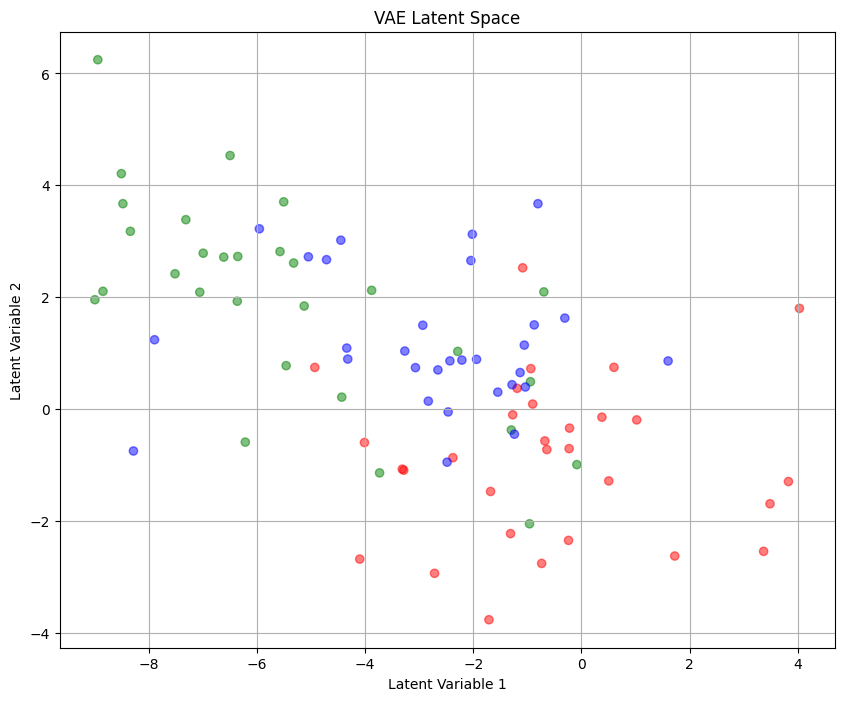

In [24]:
# Plotting
import matplotlib.pyplot as plt
dates = df['date']


date_colors = {'8/1/23': 'red', '6/1/23': 'blue', '2/1/24': 'green'}  # Adjust colors as needed
colors = [date_colors[date] for date in dates]

plt.figure(figsize=(10, 8))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=colors, alpha=0.5)
plt.xlabel("Latent Variable 1")
plt.ylabel("Latent Variable 2")
plt.title("VAE Latent Space")
plt.grid(True)
plt.show()



In [28]:
# Assuming latent_vectors is obtained from vae.encoder.predict(fish_asvs_scaled)[2]
# Assuming dates is obtained from df['date']
from google.colab import files

# Create DataFrame
latent_df = pd.DataFrame(latent_vectors, columns=['Latent Variable 1', 'Latent Variable 2'])
latent_df['Date'] = dates  # Assuming 'dates' is the 'date' metadata from your original DataFrame

# Save to CSV
latent_df.to_csv('latent_space_info.csv', index=False)
files.download('latent_space_info.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>